### Test energy conservation v05 Akantu

In [12]:
import numpy as np
import subprocess
import akantu as aka

from TFunctions import *

### Inputs

In [13]:
# Material
young_modulus = 275e9  # (Pa)
density = 2.75e3  # (kg/m3)
fracture_energy = 100.0  # (N/m)
stress_limit = 300e6  # (Pa)


# Geometry
bar_length = 50 * 10**-3  # (m)
x0 = -0.5 * bar_length  # Left extremitiy x coordinate / 0-initial
xf = 0.5 * bar_length  # Rigth extremitiy x coordinate / f-final
n_elements = 1000 * 2 # Total number of triangular elements
area = 1.0  # Cross sectional area (m2) (Equal to element size )


# Load
strain_rate = 10.0**4  # (s-1)
applied_vel = strain_rate * bar_length * 0.5
time_simulation = 4e-7 #(s)


subprocess.run("mkdir LOG", shell=True)
subprocess.run("mkdir paraview", shell=True)
subprocess.run("mkdir output", shell=True)

mkdir: cannot create directory ‘LOG’: File exists
mkdir: cannot create directory ‘paraview’: File exists
mkdir: cannot create directory ‘output’: File exists


CompletedProcess(args='mkdir output', returncode=1)

### Mesh

In [14]:
filepath_save_results = "output/"

# Mesh
h_uniform = bar_length / (n_elements * 0.5)

geometry_file = f"""
Point(1) = {{ {x0}, 0, 0, {h_uniform} }};
Point(2) = {{ {xf}, 0, 0, {h_uniform} }};
Point(3) = {{ {xf}, {h_uniform}, 0, {h_uniform} }};
Point(4) = {{ {x0}, {h_uniform}, 0, {h_uniform} }};

Line(1) = {{1,2}};
Line(2) = {{2,3}};
Line(3) = {{3,4}};
Line(4) = {{4,1}};

Line Loop(1) = {{1,2,3,4}};
Plane Surface(1) = {{1}};
Physical Surface(1) = {{1}};
Physical Line("Yblocked") = {{1,3}};
Physical Line("right") = {{2}};
Physical Line("left") = {{4}};

Transfinite Surface {1} Left;
"""

with open("LOG/bar.geo", "w") as f:
    f.write(geometry_file)

ret = subprocess.run(
    "gmsh -2 -order 1 -o LOG/bar.msh LOG/bar.geo", shell=True
)
if ret.returncode:
    print("FATAL    : Gmsh error")
else:
    print("Info    : Mesh generated")

# Contact penalty
alpha = (
    stress_limit**2
    + 4.5
    * strain_rate ** (2 / 3)
    * young_modulus
    * fracture_energy ** (2 / 3)
    * density ** (1 / 3)
) / (4.5 * fracture_energy)

material_file = f"""
seed = 1.0
model solid_mechanics_model_cohesive [

    material elastic [
        name = linear
        rho = {density}
        E = {young_modulus} 
        nu = 0.  
        finite_deformation = true
    ]

    material cohesive_linear [
        name = insertion
        sigma_c = {stress_limit} uniform [-1e6, 1e6] # critical stress 
        G_c = {fracture_energy} 
        beta = 0.
        penalty = {alpha}
    ]
]
"""

with open("LOG/material.dat", "w") as f:
    f.write(material_file)


# Read material file to akantu
aka.parseInput("LOG/material.dat")

# Read mesh
spatial_dimension = 2
mesh = aka.Mesh(spatial_dimension)
mesh.read("LOG/bar.msh")

# Get number of nodes
n_nodes = mesh.getNbNodes()
# Get connectivity list
connect = mesh.getConnectivity(aka._triangle_3)
# Get coordinates
node_coord = mesh.getNodes()

Info    : Running '/home/dantas/projects/dynamicfragmentation1D/.venv/bin/gmsh -2 -order 1 -o LOG/bar.msh LOG/bar.geo' [Gmsh 4.11.0, 1 node, max. 1 thread]
Info    : Started on Tue May  2 13:43:01 2023
Info    : Reading 'LOG/bar.geo'...
Info    : Done reading 'LOG/bar.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00109277s, CPU 0s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.000435957s, CPU 0s)
Info    : 2002 nodes 4006 elements
Info    : Writing 'LOG/bar.msh'...
Info    : Done writing 'LOG/bar.msh'
Info    : Stopped on Tue May  2 13:43:01 2023 (From start: Wall 0.026182s, CPU 0.293626s)
Info    : Mesh generated


### Model

In [15]:
# Create model a model
dynfrag = aka.SolidMechanicsModelCohesive(mesh)
dynfrag.initFull(_analysis_method=aka._static, _is_extrinsic=True)

# Configure static solver
solver = dynfrag.getNonLinearSolver("static")
solver.set("max_iterations", 100)
solver.set("threshold", 1e-10)
solver.set("convergence_type", aka.SolveConvergenceCriteria.residual)
# Add solver
dynfrag.initNewSolver(aka._explicit_lumped_mass)


# Configure cohesive element insertion
use_automatic_insertion = False
if use_automatic_insertion == True:
    dynfrag.updateAutomaticInsertion()
else:
    mesh_facets = mesh.getMeshFacets()
    connect_facets = mesh_facets.getConnectivities()
    facets_coords = mesh_facets.getNodes()

    # Get the cohesive inserter and check facets
    cohesive_inserter = dynfrag.getElementInserter()
    check_facets = cohesive_inserter.getCheckFacets()
    up = np.array([0.0, 1.0])
    # Loop by all facet types used in the simulation
    for facet_type in connect_facets.elementTypes(dim= spatial_dimension - 1):
        conn_facettype = connect_facets(facet_type)
        check_facettype = check_facets(facet_type)
        for el, conn_facettype in enumerate(conn_facettype):
            # Check the direction of the vector
            dir_vec = (
             node_coord[conn_facettype[1], :]
                - node_coord[conn_facettype[0], :]
            )
            direction = (dir_vec / np.linalg.norm(dir_vec)).dot(up)
            # If the direction is not 1 it means that is a diagonal facet, then assign False
            if abs(direction) < 0.99:
                check_facettype[el] = False




# Set time increment
dt_crit = dynfrag.getStableTimeStep()
dt = dt_crit * 0.1
dynfrag.setTimeStep(dt)
n_steps = int (time_simulation / dt)


# Apply Dirichlet BC to block dispacements at y direction on top and botton of the elements
dynfrag.applyBC(aka.FixedValue(0.0, aka._y), "Yblocked")

# Apply constant velocity at the boundaries
left_extremity = FixedVelocity(aka._x,  -applied_vel)
right_extremity = FixedVelocity(aka._x, applied_vel)
dynfrag.applyBC(left_extremity, "left")
dynfrag.applyBC(right_extremity, "right")


def applyVel(current_time_step):
    left_extremity.set_time(dt * current_time_step)
    right_extremity.set_time(dt * current_time_step)
    dynfrag.applyBC(left_extremity, "left")
    dynfrag.applyBC(right_extremity, "right")

In [16]:
# Initial values
u0 = dynfrag.getDisplacement()
v0 = dynfrag.getVelocity()
v0[:, 0] = np.array([ strain_rate * x for x, y in mesh.getNodes()])
dynfrag.getVelocity()[:] = v0
data_bc = [0,0]

# Initiation of variables
# energy_potential = 0.0
# energy_kinetic = 0.0
# energy_dissipated = 0.0
# energy_reversible = 0.0
# energy_contact = 0.0
# external_work = 0.0
# work_previous_step = 0.0
# energies = []
# energies = [[
#         ["energy potential", energy_potential],
#         ["energy kinetic", energy_kinetic],
#         ["energy dissipated", energy_dissipated],
#         ["energy reversible", energy_reversible],
#         ["energy contact", energy_contact],
#         ["external work", external_work],
#     ]]
# Initiation of variables
energy_potential = np.zeros(n_steps)
energy_kinetic = np.zeros(n_steps)
energy_dissipated = np.zeros(n_steps)
energy_reversible = np.zeros(n_steps)
energy_contact = np.zeros(n_steps)
external_work = np.zeros(n_steps)
work_previous_step = 0.0


avg_stress_bar = np.zeros(n_steps)
n_fragments = np.zeros(n_steps)

# add files to paraview :
dynfrag.setBaseName("bar")
dynfrag.addDumpFieldVector("displacement")
dynfrag.addDumpFieldVector("velocity")
dynfrag.addDumpField("strain")
dynfrag.addDumpField("stress")
dynfrag.addDumpField("blocked_dofs")
dynfrag.addDumpField("material_index")

# VTK plot for Cohesive model
dynfrag.setBaseNameToDumper("cohesive elements", "cohesive")
dynfrag.addDumpFieldVectorToDumper("cohesive elements", "displacement")
dynfrag.addDumpFieldToDumper("cohesive elements", "damage")
dynfrag.addDumpFieldVectorToDumper("cohesive elements", "tractions")
dynfrag.addDumpFieldVectorToDumper("cohesive elements", "opening")



### Main loop

In [17]:

for n in range(n_steps):

    if n%10 == 0:
        dynfrag.dump()
        dynfrag.dump("cohesive elements")
    applyVel(n)

    # Run simulation
    dynfrag.checkCohesiveStress()
    dynfrag.solveStep("explicit_lumped")
    
    fint_current_step = dynfrag.getInternalForce()[:, 0]
    stress = dynfrag.getMaterial(0).getStress(aka._triangle_3)
    stress_xx = stress[:, 0]
    avg_stress_bar[n] = np.mean(stress_xx)

    u = dynfrag.getDisplacement()[:, 0]
    v = dynfrag.getVelocity()[:, 0]
    acel = dynfrag.getAcceleration()[:, 0]


    # Energy balance
    energy_potential[n] = dynfrag.getEnergy("potential")
    energy_kinetic[n] = dynfrag.getEnergy("kinetic")
    energy_dissipated[n] = dynfrag.getEnergy("dissipated")
    energy_reversible[n] = dynfrag.getEnergy("reversible")
    energy_contact[n] = dynfrag.getEnergy("cohesive contact")
    # External work
    nodes_bc_left = mesh.getElementGroup("left").getNodeGroup().getNodes()
    nodes_bc_right = mesh.getElementGroup("right").getNodeGroup().getNodes()
    # Internal for at the current time step
    fint_current_step_bcleft = -np.sum(fint_current_step[nodes_bc_left])
    fint_current_step_bcright = -np.sum(fint_current_step[nodes_bc_right])
    # The reaction force is taken as an average between the internal force in the current and previous time-set
    freact_previous_step_bcleft = data_bc[0]
    freact_previous_step_bcright = data_bc[1]

    freact_bcleft = (fint_current_step_bcleft + freact_previous_step_bcleft) * 0.5
    freact_bcright = (fint_current_step_bcright + freact_previous_step_bcright) * 0.5
    external_work[n] = (
        work_previous_step
        + (freact_bcleft * -applied_vel + freact_bcright * applied_vel)
        * dt
    )
    work_previous_step = external_work[n]
    data_bc = [freact_bcleft, freact_bcright]
    
    
    # if n > 0:
    #     energies.append([
    #         ["energy potential", energy_potential],
    #         ["energy kinetic", energy_kinetic],
    #         ["energy dissipated", energy_dissipated],
    #         ["energy reversible", energy_reversible],
    #         ["energy contact", energy_contact],
    #         ["external work", external_work],
    #     ])


    # Fragmentation data
    fragment_data = aka.FragmentManager(dynfrag)
    fragment_data.computeAllData()

    # Number of fragments
    n_fragments[n] = fragment_data.getNbFragment()  

energies = [
        ["energy potential", energy_potential],
        ["energy kinetic", energy_kinetic],
        ["energy dissipated", energy_dissipated],
        ["energy reversible", energy_reversible],
        ["energy contact", energy_contact],
        ["external work", external_work],
    ]


### Post Process

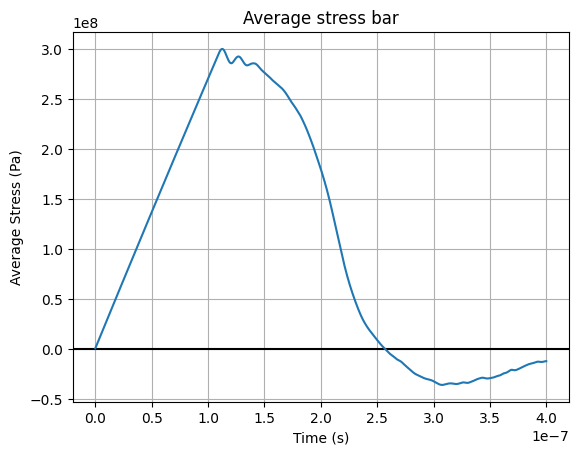

In [18]:
# Plot average stress
plotAverageStressBar(avg_stress_bar, time_simulation, n_steps)

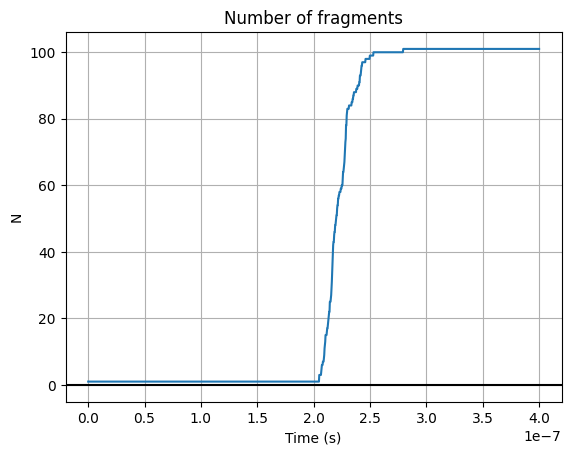

In [19]:
# Plot number of fragments
plotNumberFragments(n_fragments, time_simulation, n_steps)

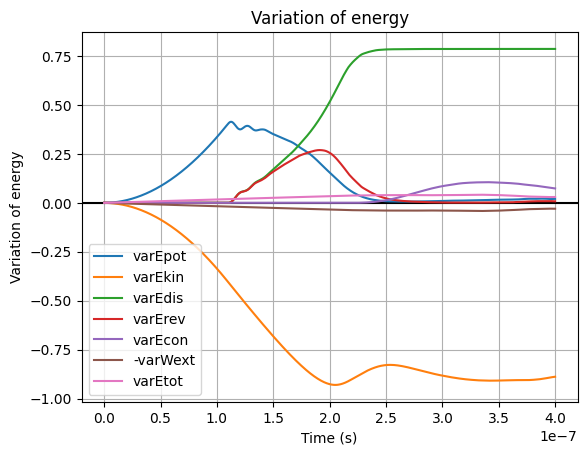

In [20]:
#  Plot variation of energy
var_energies = computeVariationEnergy(energies, n_steps)
plotVarEnergies(var_energies, time_simulation, n_steps)

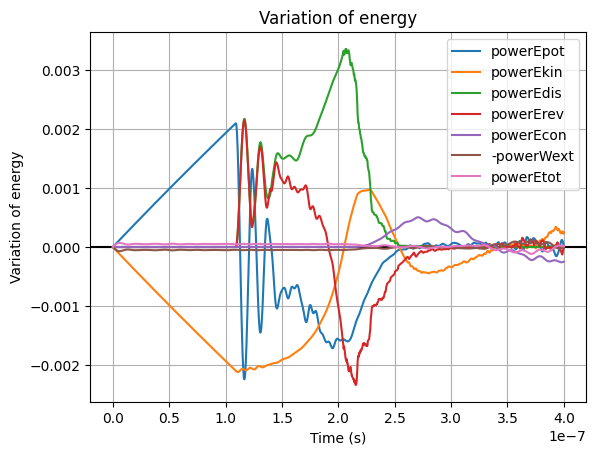

In [21]:
# Plot power
power = computePower(energies, n_steps)
plotPower(power, time_simulation, n_steps)